In [1]:
import unified_ar as ar
ar.reload()
import os
while "datasets" not in os.listdir():
    os.chdir("..")
# import unified_ar.general.libinstall
from unified_ar.constants import methods
import pandas as pd
import numpy as np
from ipywidgets import interact,interact_manual


2023-11-25 13:23:16.168680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 13:23:16.220518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 13:23:16.221717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 13:23:18.913719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Please install GPU version of TF
Please install GPU version of TF


2023-11-25 13:23:24.623331: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-25 13:23:24.663014: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
@interact(dataset={d['method']().data_dscr:i for i,d in enumerate(methods.dataset)})
def dataset_select(dataset=0):
    global datasetdscr
    datasetdscr=methods.dataset[dataset]['method']().load()
    # datasetdscr = methods.dataset[2m]['method']().load()
    print(f'dataset {datasetdscr.data_dscr} loaded')
    datasetdscr.activities_map

interactive(children=(Dropdown(description='dataset', options={'Home1': 0, 'Home2': 1, 'Aruba': 2, 'KaryoAdlNo…

In [3]:
ar.reload()
evalmethod=ar.evaluation.SplitEval.SplitEval()
evalmethod.dataset=datasetdscr
Train,Test=evalmethod.makeTrainTest(datasetdscr.sensor_events,datasetdscr.activity_events)
Train.acts=list(datasetdscr.activities_map.keys())
Test.acts=list(datasetdscr.activities_map.keys())
Train.act_map=datasetdscr.activities_map
Test.act_map=datasetdscr.activities_map

Please install GPU version of TF


2023-11-25 13:24:03.091165: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
ar.reload()
preprocessing=methods.preprocessing[0]['method']()
TrainData=preprocessing.process(datasetdscr,Train)
TestData=preprocessing.process(datasetdscr,Test)

Please install GPU version of TF


2023-11-25 13:24:05.130472: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
def customSplit(sensor_events, activity_events, start, end):
        Train0 = utils.Data(f'train_random_days {start}-{end}')
        Train0.s_events = sensor_events.loc[(sensor_events.time >= start) & (sensor_events.time < end)]
        act_filter = [] if activity_events is None else (activity_events.StartTime >= start) & (activity_events.StartTime < end)
        Train0.a_events = activity_events.loc[act_filter]
        Train0.s_event_list = Train0.s_events.values
        return Train0
self=ar.Data('md')
self.meta_size=pd.to_timedelta('24h')
self.meta_step_period=self.meta_size*1
self.meta_mode= 'keras'    
self.customSplit=customSplit
methods.run_names['fold']=0

In [9]:
import unified_ar.general.Cache as Cache
import logging
import unified_ar.general.utils as utils
ar.reload()
logger = logging.getLogger('a')

s_events=TrainData.s_events
a_events=TrainData.a_events
acts=Train.acts
if 1:
        Cache.GlobalDisable = True
        meta_features = []
        meta_targets = []
        from unified_ar.constants import methods
        def_segments = methods.segmentation
        self.segmentor_dic = {p['method']().shortname(): p for p in methods.meta_segmentation_sub_tasks}
        import unified_ar.ml_strategy.Simple
        import logging

        fast_strategy = unified_ar.ml_strategy.Simple.NormalStrategy()

        selectedSeg = methods.meta_segmentation_sub_tasks[0].copy()
        selectedSeg['findopt'] = False
        methods.segmentation = [selectedSeg]
        methods.classifier = [methods.classifier[0]]
        methods.combiner=[methods.combiner[0]]
        methods.feature_extraction=[methods.feature_extraction[0]]
        methods.dataset=[methods.dataset[0]]
        methods.mlstrategy=[methods.mlstrategy[0]]
                        
        logger.debug('train using all the data with the first segment method')
        logger.debug(f'method={selectedSeg["method"]().shortname()}')
        seg_params = [f"{p['var']}:{p['init']}" for p in selectedSeg["params"]]
        logger.debug(f'params={seg_params}')
        fast_strategy.ui_debug = {'seg': 1}
        Train0 = utils.Data(f'train_all_days')
        Train0.s_events = s_events
        Train0.s_events_list = s_events.values
        Train0.a_events = a_events
        def_run_names = methods.run_names.copy()

        methods.run_names['out'] = f"{def_run_names['out']}/base"
        result = fast_strategy.train(datasetdscr, Train0, acts, update_model=False)
        methods.run_names['meta_base'] = methods.run_names['out']

        logger.debug(f'result of full data training {result}')
        logger.debug(fast_strategy.get_info().functions)



Please install GPU version of TF
[13:27:02] 1796851765.py <module>   DEBUG    train using all the data with the first segment method
[13:27:02] 1796851765.py <module>   DEBUG    method=FixedEventWindow
[13:27:02] 1796851765.py <module>   DEBUG    params=['size:5', 'shift:2']
[13:27:02] OptLearn.py run        DEBUG    SimplePreprocessing_FixedEventWindow_CookActivityFetcher_SensorWord_FCN_EmptyCombiner2_Accuracy_Accuracy_ start
[13:27:02] OptLearn.py convertToArray DEBUG    <FixedEventWindow> {'findopt': False, 'defparams': [{'var': 'size', 'min': 2, 'max': 30, 'type': 'int', 'init': 5, 'range': [2, 5, 8, 11, 15, 20, 30]}, {'var': 'shift', 'min': 2, 'max': 20, 'type': 'int', 'init': 2, 'range': [2, 5, 8, 11, 15, 20]}], 'params': {'shift': 2, 'size': 5}, 'shift': 2, 'size': 5, 'func': <unified_ar.common.data.Data object at 0x7ff95451e280>}
[13:27:02] OptLearn.py convertToArray DEBUG    SensorWord
[13:27:02] OptLearn.py convertToArray DEBUG    <FCN> {'findopt': False, 'defparams': [{'epoc

2023-11-25 13:27:02.821210: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


FixedEventWindow {'size': 5, 'shift': 2}: |          count=0 time=00:00 speed=?it/s

[13:27:02] Simple.py  pipeline   DEBUG    Segmentation Finished 1251 segment created FixedEventWindow


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

[13:27:03] Simple.py  pipeline   DEBUG    FeatureExtraction Finished shape (1251, 50) , SensorWord
shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 50, 1)             0         
                                                                 
 conv1d_9 (Conv1D)           (None, 50, 128)           1152      
                                                                 
 batch_normalization_9 (Bat  (None, 50, 128)           512       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 50, 128)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 50, 256)           164096    
                                                                 
 batch_normalization_10 (Ba  (None, 50, 256)           1024      
 tchNormalization)                                             

In [39]:
if 1:
        logger.debug(f'now finding the best seg method for each meta segmets size={self.meta_size} step={self.meta_step_period}')
        # logging.getLogger().setLevel(logging.INFO)
        logging.getLogger().handlers[1].setLevel(logging.INFO)
        fast_strategy.ui_debug = {'seg': 0}
        methods.segmentation = methods.meta_segmentation_sub_tasks

        starts = s_events.time.dt.floor(self.meta_step_period).unique()
        ends = starts + self.meta_size
        new_meta_dataset={'method_selector':{'targets':[],'features':[]},'params_selector':{
            m['method']().shortname():{'targets':[],'features':[]} for m in  methods.meta_segmentation_sub_tasks
            }}
        meta_features=[]
        for s, e in zip(starts, ends):
            methods.run_names['out'] = f"{def_run_names['out']}/{s}-{e}"
            data2 = self.customSplit(s_events, a_events, s, e)
            logger.debug(f's={s} : {e}============= #sevent={len(data2.s_events)} #aevents={len(data2.a_events)}')
            if len(data2.s_events) == 0 or len(data2.a_events) == 0:
                continue

            result = fast_strategy.train(datasetdscr, data2, acts, update_model=True)
            if result is None:
                continue
            logger.debug(fast_strategy.get_info().functions)
            # result=fast_strategy.pipeline(fast_strategy.functions,self.traindata,train=True)
            feat=self.get_meta_features(datasetdscr,s,e,data2)
            meta_features.append(feat)
            seg = result.functions['segmentor']
            meta_targets.append({'method': seg[0], **result.quality, **{p: seg[1][p] for p in seg[1]}})
            new_meta_dataset['method_selector']['targets'].append({'method': seg[0], **result.quality})
            new_meta_dataset['method_selector']['features'].append(feat)
            # self.strategy=fast_strategy
            sortedJobs = sorted(fast_strategy.opt_history, key=lambda job: job.result['optq']['q'])
            for p in new_meta_dataset['params_selector']:
                for job in sortedJobs:
                    seg=job.functions.segmentor.shortname()
                    if seg==p:
                        new_meta_dataset['params_selector'][p]['targets'].append(job.functions.segmentor.params)
                        new_meta_dataset['params_selector'][p]['features'].append(feat)
                        break


        methods.segmentation = def_segments
        methods.run_names = def_run_names
        # logging.getLogger().setLevel(logging.DEBUG)
        logging.getLogger().handlers[1].setLevel(logging.DEBUG)
        meta_dataset = {'meta_features': pd.DataFrame(meta_features), 'meta_targets': pd.DataFrame(meta_targets)}
        new_meta_dataset['method_selector']={'features': pd.DataFrame(new_meta_dataset['method_selector']['features']), 'targets': pd.DataFrame(new_meta_dataset['method_selector']['targets'])}
        utils.saveState(meta_dataset, f"meta_dataset/{methods.run_names['out']}_{methods.run_names['fold']}")

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (127, 50)
shape (127, 50)
shape (127, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_363 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1089 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1089 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1089 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1090 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1090 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_364 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1092 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1092 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1092 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1093 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1093 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_365 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1095 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1095 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1095 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1096 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1096 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_366 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1098 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1098 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1098 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1099 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1099 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_367 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1101 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1101 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1101 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1102 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1102 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_368 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1104 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1104 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1104 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1105 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1105 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_369 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1107 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1107 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1107 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1108 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1108 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_370 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1110 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1110 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1110 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1111 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1111 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_371 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1113 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1113 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1113 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1114 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1114 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_372 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1116 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1116 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1116 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1117 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1117 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_373 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1119 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1119 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1119 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1120 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1120 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_374 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1122 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1122 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1122 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1123 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1123 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_375 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1125 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1125 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1125 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1126 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1126 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_376 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1128 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1128 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1128 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1129 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1129 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_377 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1131 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1131 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1131 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1132 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1132 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_378 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1134 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1134 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1134 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1135 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1135 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_379 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1137 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1137 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1137 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1138 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1138 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_380 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1140 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1140 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1140 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1141 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1141 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_381 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1143 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1143 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1143 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1144 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1144 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_382 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1146 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1146 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1146 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1147 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1147 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_383 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1149 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1149 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1149 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1150 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1150 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_384 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1152 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1152 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1152 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1153 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1153 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_385 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1155 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1155 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1155 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1156 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1156 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_386 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1158 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1158 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1158 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1159 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1159 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_387 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1161 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1161 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1161 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1162 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1162 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_388 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1164 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1164 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1164 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1165 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1165 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (53, 50)
shape (53, 50)
shape (53, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_389 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1167 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1167 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1167 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1168 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1168 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_390 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1170 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1170 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1170 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1171 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1171 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_391 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1173 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1173 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1173 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1174 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1174 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_392 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1176 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1176 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1176 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1177 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1177 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_393 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1179 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1179 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1179 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1180 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1180 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_394 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1182 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1182 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1182 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1183 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1183 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_395 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1185 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1185 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1185 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1186 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1186 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_396 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1188 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1188 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1188 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1189 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1189 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_397 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1191 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1191 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1191 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1192 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1192 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_398 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1194 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1194 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1194 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1195 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1195 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_399 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1197 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1197 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1197 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1198 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1198 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_400 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1200 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1200 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1200 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1201 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1201 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_401 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1203 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1203 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1203 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1204 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1204 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_402 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1206 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1206 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1206 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1207 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1207 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_403 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1209 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1209 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1209 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1210 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1210 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_404 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1212 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1212 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1212 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1213 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1213 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_405 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1215 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1215 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1215 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1216 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1216 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_406 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1218 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1218 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1218 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1219 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1219 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_407 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1221 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1221 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1221 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1222 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1222 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_408 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1224 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1224 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1224 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1225 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1225 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_409 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1227 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1227 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1227 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1228 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1228 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_410 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1230 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1230 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1230 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1231 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1231 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_411 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1233 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1233 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1233 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1234 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1234 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_412 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1236 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1236 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1236 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1237 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1237 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_413 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1239 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1239 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1239 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1240 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1240 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_414 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1242 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1242 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1242 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1243 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1243 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_415 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1245 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1245 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1245 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1246 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1246 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (256, 50)
shape (256, 50)
shape (256, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (100, 50)
shape (100, 50)
shape (100, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_416 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1248 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1248 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1248 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1249 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1249 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_417 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1251 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1251 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1251 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1252 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1252 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_418 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1254 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1254 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1254 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1255 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1255 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_419 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1257 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1257 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1257 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1258 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1258 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_420 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1260 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1260 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1260 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1261 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1261 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_421 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1263 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1263 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1263 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1264 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1264 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_422 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1266 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1266 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1266 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1267 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1267 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_423 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1269 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1269 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1269 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1270 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1270 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_424 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1272 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1272 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1272 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1273 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1273 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_425 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1275 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1275 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1275 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1276 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1276 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_426 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1278 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1278 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1278 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1279 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1279 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_427 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1281 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1281 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1281 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1282 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1282 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_428 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1284 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1284 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1284 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1285 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1285 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_429 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1287 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1287 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1287 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1288 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1288 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_430 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1290 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1290 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1290 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1291 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1291 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_431 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1293 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1293 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1293 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1294 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1294 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_432 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1296 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1296 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1296 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1297 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1297 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_433 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1299 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1299 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1299 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1300 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1300 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_434 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1302 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1302 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1302 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1303 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1303 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_435 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1305 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1305 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1305 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1306 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1306 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_436 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1308 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1308 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1308 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1309 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1309 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_437 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1311 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1311 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1311 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1312 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1312 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_438 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1314 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1314 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1314 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1315 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1315 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_439 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1317 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1317 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1317 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1318 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1318 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_440 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1320 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1320 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1320 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1321 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1321 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_441 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1323 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1323 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1323 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1324 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1324 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (36, 50)
shape (36, 50)
shape (36, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_442 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1326 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1326 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1326 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1327 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1327 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_443 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1329 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1329 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1329 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1330 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1330 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_444 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1332 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1332 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1332 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1333 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1333 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_445 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1335 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1335 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1335 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1336 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1336 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_446 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1338 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1338 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1338 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1339 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1339 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_447 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1341 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1341 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1341 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1342 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1342 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_448 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1344 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1344 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1344 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1345 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1345 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_449 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1347 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1347 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1347 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1348 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1348 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_450 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1350 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1350 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1350 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1351 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1351 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_451 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1353 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1353 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1353 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1354 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1354 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_452 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1356 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1356 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1356 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1357 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1357 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_453 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1359 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1359 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1359 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1360 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1360 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_454 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1362 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1362 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1362 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1363 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1363 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_455 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1365 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1365 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1365 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1366 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1366 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_456 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1368 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1368 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1368 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1369 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1369 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_457 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1371 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1371 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1371 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1372 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1372 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_458 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1374 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1374 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1374 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1375 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1375 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_459 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1377 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1377 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1377 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1378 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1378 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_460 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1380 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1380 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1380 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1381 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1381 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_461 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1383 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1383 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1383 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1384 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1384 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_462 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1386 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1386 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1386 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1387 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1387 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_463 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1389 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1389 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1389 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1390 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1390 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_464 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1392 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1392 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1392 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1393 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1393 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_465 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1395 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1395 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1395 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1396 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1396 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_466 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1398 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1398 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1398 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1399 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1399 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_467 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1401 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1401 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1401 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1402 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1402 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_468 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1404 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1404 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1404 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1405 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1405 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (201, 50)
shape (201, 50)
shape (201, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (144, 50)
shape (144, 50)
shape (144, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_469 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1407 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1407 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1407 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1408 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1408 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_470 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1410 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1410 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1410 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1411 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1411 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_471 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1413 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1413 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1413 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1414 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1414 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_472 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1416 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1416 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1416 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1417 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1417 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_473 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1419 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1419 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1419 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1420 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1420 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_474 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1422 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1422 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1422 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1423 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1423 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_475 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1425 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1425 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1425 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1426 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1426 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_476 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1428 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1428 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1428 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1429 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1429 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_477 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1431 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1431 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1431 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1432 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1432 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_478 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1434 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1434 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1434 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1435 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1435 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_479 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1437 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1437 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1437 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1438 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1438 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_480 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1440 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1440 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1440 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1441 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1441 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_481 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1443 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1443 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1443 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1444 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1444 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_482 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1446 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1446 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1446 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1447 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1447 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_483 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1449 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1449 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1449 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1450 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1450 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_484 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1452 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1452 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1452 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1453 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1453 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_485 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1455 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1455 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1455 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1456 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1456 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_486 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1458 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1458 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1458 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1459 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1459 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_487 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1461 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1461 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1461 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1462 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1462 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_488 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1464 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1464 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1464 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1465 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1465 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_489 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1467 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1467 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1467 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1468 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1468 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_490 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1470 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1470 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1470 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1471 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1471 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_491 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1473 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1473 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1473 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1474 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1474 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_492 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1476 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1476 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1476 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1477 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1477 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_493 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1479 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1479 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1479 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1480 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1480 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_494 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1482 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1482 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1482 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1483 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1483 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (57, 50)
shape (57, 50)
shape (57, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_495 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1485 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1485 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1485 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1486 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1486 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_496 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1488 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1488 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1488 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1489 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1489 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_497 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1491 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1491 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1491 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1492 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1492 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_498 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1494 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1494 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1494 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1495 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1495 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_499 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1497 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1497 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1497 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1498 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1498 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_500 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1500 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1500 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1500 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1501 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1501 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_501 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1503 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1503 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1503 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1504 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1504 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_502 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1506 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1506 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1506 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1507 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1507 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_503 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1509 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1509 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1509 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1510 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1510 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_504 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1512 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1512 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1512 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1513 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1513 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_505 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1515 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1515 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1515 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1516 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1516 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_506 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1518 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1518 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1518 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1519 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1519 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_507 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1521 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1521 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1521 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1522 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1522 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_508 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1524 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1524 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1524 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1525 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1525 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_509 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1527 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1527 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1527 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1528 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1528 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_510 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1530 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1530 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1530 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1531 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1531 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_511 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1533 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1533 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1533 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1534 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1534 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_512 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1536 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1536 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1536 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1537 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1537 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_513 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1539 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1539 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1539 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1540 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1540 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_514 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1542 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1542 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1542 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1543 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1543 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_515 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1545 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1545 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1545 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1546 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1546 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_516 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1548 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1548 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1548 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1549 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1549 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_517 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1551 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1551 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1551 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1552 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1552 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_518 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1554 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1554 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1554 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1555 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1555 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_519 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1557 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1557 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1557 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1558 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1558 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_520 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1560 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1560 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1560 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1561 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1561 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_521 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1563 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1563 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1563 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1564 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1564 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (289, 50)
shape (289, 50)
shape (289, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (267, 50)
shape (267, 50)
shape (267, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_522 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1566 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1566 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1566 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1567 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1567 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_523 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1569 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1569 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1569 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1570 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1570 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_524 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1572 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1572 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1572 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1573 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1573 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_525 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1575 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1575 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1575 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1576 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1576 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_526 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1578 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1578 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1578 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1579 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1579 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_527 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1581 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1581 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1581 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1582 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1582 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_528 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1584 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1584 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1584 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1585 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1585 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_529 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1587 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1587 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1587 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1588 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1588 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_530 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1590 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1590 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1590 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1591 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1591 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_531 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1593 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1593 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1593 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1594 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1594 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_532 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1596 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1596 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1596 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1597 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1597 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_533 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1599 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1599 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1599 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1600 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1600 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_534 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1602 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1602 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1602 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1603 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1603 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_535 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1605 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1605 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1605 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1606 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1606 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_536 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1608 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1608 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1608 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1609 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1609 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_537 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1611 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1611 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1611 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1612 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1612 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_538 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1614 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1614 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1614 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1615 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1615 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_539 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1617 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1617 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1617 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1618 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1618 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_540 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1620 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1620 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1620 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1621 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1621 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_541 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1623 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1623 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1623 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1624 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1624 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_542 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1626 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1626 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1626 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1627 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1627 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_543 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1629 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1629 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1629 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1630 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1630 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_544 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1632 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1632 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1632 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1633 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1633 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_545 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1635 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1635 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1635 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1636 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1636 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_546 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1638 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1638 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1638 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1639 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1639 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_547 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1641 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1641 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1641 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1642 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1642 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (104, 50)
shape (104, 50)
shape (104, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_548 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1644 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1644 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1644 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1645 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1645 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_549 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1647 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1647 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1647 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1648 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1648 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_550 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1650 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1650 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1650 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1651 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1651 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_551 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1653 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1653 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1653 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1654 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1654 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_552 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1656 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1656 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1656 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1657 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1657 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_553 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1659 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1659 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1659 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1660 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1660 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_554 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1662 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1662 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1662 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1663 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1663 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_555 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1665 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1665 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1665 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1666 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1666 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_556 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1668 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1668 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1668 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1669 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1669 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_557 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1671 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1671 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1671 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1672 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1672 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_558 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1674 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1674 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1674 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1675 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1675 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_559 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1677 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1677 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1677 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1678 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1678 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_560 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1680 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1680 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1680 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1681 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1681 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_561 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1683 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1683 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1683 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1684 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1684 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_562 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1686 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1686 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1686 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1687 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1687 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_563 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1689 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1689 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1689 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1690 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1690 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_564 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1692 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1692 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1692 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1693 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1693 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_565 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1695 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1695 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1695 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1696 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1696 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_566 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1698 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1698 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1698 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1699 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1699 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_567 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1701 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1701 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1701 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1702 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1702 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_568 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1704 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1704 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1704 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1705 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1705 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_569 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1707 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1707 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1707 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1708 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1708 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_570 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1710 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1710 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1710 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1711 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1711 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_571 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1713 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1713 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1713 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1714 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1714 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_572 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1716 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1716 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1716 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1717 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1717 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_573 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1719 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1719 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1719 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1720 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1720 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_574 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1722 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1722 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1722 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1723 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1723 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (536, 50)
shape (536, 50)
shape (536, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (180, 50)
shape (180, 50)
shape (180, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_575 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1725 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1725 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1725 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1726 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1726 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_576 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1728 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1728 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1728 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1729 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1729 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_577 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1731 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1731 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1731 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1732 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1732 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_578 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1734 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1734 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1734 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1735 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1735 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_579 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1737 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1737 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1737 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1738 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1738 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_580 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1740 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1740 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1740 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1741 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1741 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_581 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1743 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1743 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1743 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1744 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1744 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_582 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1746 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1746 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1746 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1747 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1747 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_583 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1749 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1749 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1749 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1750 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1750 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_584 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1752 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1752 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1752 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1753 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1753 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_585 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1755 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1755 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1755 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1756 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1756 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_586 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1758 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1758 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1758 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1759 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1759 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_587 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1761 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1761 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1761 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1762 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1762 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_588 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1764 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1764 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1764 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1765 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1765 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_589 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1767 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1767 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1767 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1768 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1768 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_590 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1770 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1770 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1770 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1771 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1771 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_591 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1773 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1773 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1773 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1774 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1774 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_592 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1776 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1776 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1776 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1777 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1777 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_593 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1779 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1779 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1779 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1780 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1780 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_594 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1782 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1782 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1782 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1783 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1783 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_595 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1785 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1785 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1785 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1786 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1786 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_596 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1788 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1788 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1788 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1789 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1789 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_597 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1791 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1791 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1791 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1792 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1792 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_598 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1794 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1794 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1794 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1795 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1795 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_599 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1797 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1797 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1797 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1798 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1798 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_600 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1800 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1800 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1800 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1801 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1801 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (62, 50)
shape (62, 50)
shape (62, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_601 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1803 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1803 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1803 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1804 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1804 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_602 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1806 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1806 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1806 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1807 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1807 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_603 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1809 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1809 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1809 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1810 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1810 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_604 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1812 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1812 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1812 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1813 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1813 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_605 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1815 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1815 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1815 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1816 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1816 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_606 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1818 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1818 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1818 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1819 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1819 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_607 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1821 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1821 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1821 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1822 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1822 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_608 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1824 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1824 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1824 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1825 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1825 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_609 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1827 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1827 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1827 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1828 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1828 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_610 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1830 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1830 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1830 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1831 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1831 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_611 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1833 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1833 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1833 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1834 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1834 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_612 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1836 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1836 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1836 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1837 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1837 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_613 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1839 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1839 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1839 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1840 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1840 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_614 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1842 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1842 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1842 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1843 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1843 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_615 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1845 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1845 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1845 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1846 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1846 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_616 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1848 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1848 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1848 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1849 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1849 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_617 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1851 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1851 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1851 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1852 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1852 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_618 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1854 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1854 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1854 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1855 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1855 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_619 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1857 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1857 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1857 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1858 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1858 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_620 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1860 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1860 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1860 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1861 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1861 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_621 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1863 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1863 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1863 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1864 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1864 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_622 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1866 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1866 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1866 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1867 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1867 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_623 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1869 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1869 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1869 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1870 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1870 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_624 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1872 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1872 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1872 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1873 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1873 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_625 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1875 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1875 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1875 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1876 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1876 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_626 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1878 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1878 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1878 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1879 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1879 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_627 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1881 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1881 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1881 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1882 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1882 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (361, 50)
shape (361, 50)
shape (361, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (430, 50)
shape (430, 50)
shape (430, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_628 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1884 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1884 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1884 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1885 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1885 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_629 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1887 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1887 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1887 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1888 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1888 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_630 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1890 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1890 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1890 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1891 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1891 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_631 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1893 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1893 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1893 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1894 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1894 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_632 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1896 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1896 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1896 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1897 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1897 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_633 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1899 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1899 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1899 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1900 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1900 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_634 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1902 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1902 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1902 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1903 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1903 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_635 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1905 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1905 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1905 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1906 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1906 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_636 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1908 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1908 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1908 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1909 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1909 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_637 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1911 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1911 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1911 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1912 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1912 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_638 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1914 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1914 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1914 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1915 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1915 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_639 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1917 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1917 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1917 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1918 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1918 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_640 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1920 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1920 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1920 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1921 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1921 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_641 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1923 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1923 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1923 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1924 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1924 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_642 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1926 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1926 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1926 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1927 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1927 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_643 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1929 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1929 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1929 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1930 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1930 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_644 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1932 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1932 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1932 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1933 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1933 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_645 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1935 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1935 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1935 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1936 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1936 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_646 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1938 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1938 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1938 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1939 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1939 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_647 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1941 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1941 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1941 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1942 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1942 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_648 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1944 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1944 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1944 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1945 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1945 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_649 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1947 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1947 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1947 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1948 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1948 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_650 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1950 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1950 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1950 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1951 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1951 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_651 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1953 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1953 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1953 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1954 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1954 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_652 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1956 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1956 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1956 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1957 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1957 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_653 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1959 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1959 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1959 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1960 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1960 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (136, 50)
shape (136, 50)
shape (136, 50)


SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_654 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1962 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1962 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1962 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1963 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1963 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_655 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1965 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1965 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1965 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1966 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1966 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_656 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1968 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1968 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1968 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1969 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1969 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_657 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1971 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1971 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1971 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1972 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1972 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_658 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1974 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1974 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1974 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1975 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1975 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_659 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1977 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1977 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1977 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1978 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1978 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_660 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1980 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1980 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1980 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1981 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1981 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_661 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1983 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1983 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1983 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1984 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1984 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_662 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1986 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1986 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1986 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1987 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1987 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_663 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1989 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1989 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1989 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1990 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1990 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_664 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1992 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1992 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1992 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1993 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1993 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_665 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1995 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1995 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1995 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1996 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1996 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_666 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_1998 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_1998 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_1998 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_1999 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_1999 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_667 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2001 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2001 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2001 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2002 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2002 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_668 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2004 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2004 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2004 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2005 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2005 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_669 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2007 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2007 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2007 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2008 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2008 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_670 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2010 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2010 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2010 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2011 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2011 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_671 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2013 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2013 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2013 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2014 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2014 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_672 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2016 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2016 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2016 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2017 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2017 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_673 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2019 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2019 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2019 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2020 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2020 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_674 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2022 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2022 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2022 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2023 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2023 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_675 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2025 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2025 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2025 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2026 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2026 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_676 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2028 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2028 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2028 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2029 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2029 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_677 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2031 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2031 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2031 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2032 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2032 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_678 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2034 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2034 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2034 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2035 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2035 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_679 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2037 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2037 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2037 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2038 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2038 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_680 (Masking)       (None, 50, 1)             0         
                                                                 
 conv1d_2040 (Conv1D)        (None, 50, 128)           1152      
                                                                 
 batch_normalization_2040 (  (None, 50, 128)           512       
 BatchNormalization)                                             
                                                                 
 activation_2040 (Activatio  (None, 50, 128)           0         
 n)                                                              
                                                                 
 conv1d_2041 (Conv1D)        (None, 50, 256)           164096    
                                                                 
 batch_normalization_2041 (  (None, 50, 256)           1024    

SensorWord train {'vocab_size': 1000}:   0%|          count=0 time=00:00 speed=?it/s

shape (1, 50)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

shape (861, 50)
shape (861, 50)
shape (861, 50)


KeyError: 'fold'

In [42]:
for p,v in new_meta_dataset['params_selector'].items():
    new_meta_dataset['params_selector'][p]={
        'features': pd.DataFrame(v['features']), 'targets': pd.DataFrame(v['targets'])
    }
new_meta_dataset

{'method_selector': {'features':    AD1-A  AD1-B  AD1-C  D01  E01  I01  I02  I03  I04  I05  ...  M09  M13  M14  \
  0     13     23      3    8    0    1    2    1    2    1  ...    2   70   10   
  1     15     18     10    6    0    2    1    3    1    1  ...    2   23   17   
  2     16     58      0    8    0    4    1    1    1    2  ...    2   48   14   
  3     46     54     51   10    0    4    4    2    4    2  ...    4   90   24   
  4     67     13     57   10    0    1    1    5    2    2  ...    2   52   12   
  5    146    153     76   28    0    9    6    4    5    5  ...    4   92   65   
  
     M15  M16  M17  M18  M23  asterisk       time  
  0    7    6   89    5    0         0 2008-03-24  
  1    6    6   68   10    2         0 2008-03-26  
  2   14   13   87   11    1         0 2008-03-27  
  3   12   12  153   35    5         0 2008-03-28  
  4   12   16   88   10    2         0 2008-04-15  
  5   19   19  154   36    5         0 2008-05-21  
  
  [6 rows x 26 col

In [21]:
meta_dataset['meta_targets']['method'][meta_dataset['meta_targets']['method']=='Probabilistic'].count()

76

In [139]:
self.meta_mode ='keras'
def create_train_model(meta_dataset):
        feat_df = meta_dataset['meta_features']
        target_df = meta_dataset['meta_targets']

        ntarget = target_df.drop(['accuracy', 'precision', 'recall', 'f1'], axis=1)

        self.targetTransformer = MyTargetTransformer(self.meta_mode)
        self.targetTransformer.fit(ntarget)
        self.featTransformer = self.create_feat_transformer(feat_df)
        self.featTransformer.fit(feat_df)
        logger.debug(f"metainfo=============== feat=\n{feat_df}\n target=\n{target_df}")
        X = self.featTransformer.transform(feat_df)
        y = self.targetTransformer.transform(ntarget)
        if self.meta_mode == 'keras':
            from tensorflow import keras
            from tensorflow.keras import layers
            inputs = keras.Input(shape=(X.shape[1],))
            layer1 = layers.Dense(16, activation='relu')(inputs)
            layer2 = layers.Dense(8, activation='relu')(layer1)
            layer3 = layers.Dense(16, activation='relu')(layer2)
            classifier = layers.Dense(1, activation='softmax', name='method')(layer3)
            regressions = [layers.Dense(1, activation='linear', name=x)(layer3) for x in ntarget.columns.drop('method')]

            mdl = keras.Model(inputs=inputs, outputs=[classifier, *regressions])

            mdl.compile(loss=['categorical_crossentropy', *(['mse'] * len(regressions))], optimizer='adam', metrics=['accuracy'])
            # mdl.compile(loss=['binary_crossentropy', *(['mse'] * len(regressions))], optimizer='adam', metrics=['accuracy'])

        else:
            from sklearn.svm import SVR
            from sklearn.multioutput import MultiOutputRegressor
            mdl = MultiOutputRegressor(SVR())
        mdl.fit(X, y,epochs=100)
        return mdl


def create_feat_transformer(feat):
        import numpy as np
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
        from sklearn.model_selection import train_test_split
        from sklearn.pipeline import make_pipeline
        from unified_ar.feature_extraction.features import TimeSpliter, periodic_spline_transformer

        numeric_features = feat.columns.drop(['time'])
        numeric_transformer = MinMaxScaler()#StandardScaler()

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ('date', make_pipeline(TimeSpliter(), ColumnTransformer(
                    transformers=[
                        ("weekday", periodic_spline_transformer(7, n_splines=3), ["time_dayofweek"]),
                        ("month", periodic_spline_transformer(12, n_splines=6), ["time_month"]),
                    ]
                )), ['time']),
            ]
        )

        return preprocessor

self.create_feat_transformer=create_feat_transformer



class MyTargetTransformer:
    def __init__(self, mode):
        self.mode = mode
    is_fit = False

    def fit(self, y):
        import pandas as pd
        from sklearn import preprocessing

        self.is_fit = True
        self.trans = {'method': preprocessing.LabelEncoder(), 'other': preprocessing.MinMaxScaler()}
        y['size'].loc[y['size'].isna()]=0
        y['shift'].loc[y['shift'].isna()]=0
        self.trans['method'].fit(y['method'])
        self.trans['other'].fit(y.drop(['method'], axis=1))
        self.columns = y.columns

    def transform(self, y):
        if not self.is_fit:
            raise Error('not fit')
        y['size'].loc[y['size'].isna()]=0
        y['shift'].loc[y['shift'].isna()]=0
        
        y1 = self.trans['method'].transform(y['method'])

        y2 = self.trans['other'].transform(y.drop(['method'], axis=1))
        if self.mode == 'keras':
            res = [y1.reshape(-1, 1)]
            for i, c in enumerate(self.columns.drop(['method'])):
                res.append(y2[:, i].reshape(-1, 1))
            return res
        else:
            return y2
    #         return [self.trans[c].transform(y[[c]]) for c in self.trans]

    def inverse_transform(self, y):
        import numpy as np
        if not self.is_fit:
            raise Error('not fit')
        if self.mode == 'keras':
            y2 = np.hstack(y)
            y2[:, 1:] = np.clip(self.trans['other'].inverse_transform(y2[:, 1:]),0,120)
            
            df = pd.DataFrame(y2)
            df.columns = self.columns
            df['method'] = self.trans['method'].inverse_transform(y2[:, 0].astype(int))
            # df['method']='s'
            return df
        else:
            df = pd.DataFrame(self.trans['other'].inverse_transform(y))
            df.columns = self.columns.drop(['method'])
            return df


self.mode= 'keras'
ml=create_train_model(meta_dataset)
X = self.featTransformer.transform(meta_dataset['meta_features'])
y=self.targetTransformer.transform(meta_dataset['meta_targets'].drop(['accuracy', 'precision', 'recall', 'f1'], axis=1))
ml.evaluate(X,y)


[21:01:44] 427018605.py create_train_model DEBUG    metainfo=============== feat=
    D021  D022  D023  D024  D025  D026  D027  D028  D029  D030  ...  M012  \
0      0     0     0     0     0     0     0     0     0     0  ...    20   
1      2     8     2     0     2     4     2     0    12    30  ...    82   
2      2     6     2     1     0     6    10     2    24    32  ...    72   
3      2     6     6     1     0     4    12     0    24    12  ...    96   
4      6     6     4     0     0    10     4     4    22    32  ...    96   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
93     8     8     6     0     0     8    12     6    32    30  ...   274   
94     4     0     2     0     0     4     2     0    24    22  ...   352   
95     6     4     2     0     0     4    10     0    18    26  ...   428   
96     6     2     4     0     0     6    10     4    38    22  ...   380   
97     2     0     2     0     0     2     2     4     8     8  ...   2

/users/modaresi/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 1s 6ms/step - loss: 0.1367 - method_loss: 0.0000e+00 - size_loss: 0.0657 - shift_loss: 0.0710 - method_accuracy: 0.1939 - size_accuracy: 0.7551 - shift_accuracy: 0.7755
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1148 - method_loss: 0.0000e+00 - size_loss: 0.0592 - shift_loss: 0.0555 - method_accuracy: 0.1939 - size_accuracy: 0.7755 - shift_accuracy: 0.7755
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 0.1051 - method_loss: 0.0000e+00 - size_loss: 0.0567 - shift_loss: 0.0484 - method_accuracy: 0.1939 - size_accuracy: 0.7755 - shift_accuracy: 0.7755
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1025 - method_loss: 0.0000e+00 - size_loss: 0.0582 - shift_loss: 0.0443 - method_accuracy: 0.1939 - size_accuracy: 0.7755 - shift_accuracy: 0.7755
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1018 - method_loss: 0.0000e+00 - size_loss: 0.0586 - shift_

/users/modaresi/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


[0.2639189660549164,
 0.0,
 0.0987788736820221,
 0.16514010727405548,
 0.19387754797935486,
 0.7755101919174194,
 0.581632673740387]

In [26]:
def get_meta_features(datasetdscr,s,e,data2):
            fea = {'start_time': s, 'end_time': e}
            aggr = data2.s_events.groupby('SID').count()
            fea = {k: aggr.loc[k]['value'] if k in aggr.index else 0 for k in datasetdscr.sensor_id_map_inverse}
            fea['time'] = s
            return fea
self.get_meta_features=get_meta_features

4/4 [==============================] - 0s 2ms/step


array([[<Axes: title={'center': 'size'}>,
        <Axes: title={'center': 'shift'}>]], dtype=object)

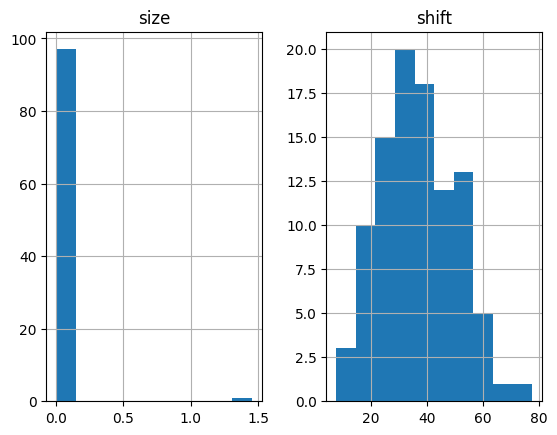

In [140]:
X = self.featTransformer.transform(meta_dataset['meta_features'])
y=self.targetTransformer.transform(meta_dataset['meta_targets'].drop(['accuracy', 'precision', 'recall', 'f1'], axis=1))
yy=ml.predict(X)

yyy=self.targetTransformer.inverse_transform(yy)
yyy.hist()

In [114]:
meta_dataset['meta_targets'].drop(['accuracy', 'precision', 'recall', 'f1'], axis=1)

,method,size,shift
0,FixedEventWindow,30.0,5.0
1,FixedEventWindow,8.0,2.0
2,FixedSlidingWindow,75.0,60.0
3,FixedSlidingWindow,15.0,15.0
4,Probabilistic,NaN,NaN
...,...,...,...
93,Probabilistic,NaN,NaN
94,Probabilistic,NaN,NaN
95,Probabilistic,NaN,NaN
96,Probabilistic,NaN,NaN


In [54]:
meta_dataset['meta_features']

,D021,D022,D023,D024,D025,D026,D027,D028,D029,D030,...,M012,M013,M014,M015,M016,M017,M018,M019,M020,time
0,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,2,6,10,8,2009-08-03
1,2,8,2,0,2,4,2,0,12,30,...,82,24,0,432,12,126,204,64,116,2009-08-04
2,2,6,2,1,0,6,10,2,24,32,...,72,14,12,248,8,90,188,36,20,2009-08-05
3,2,6,6,1,0,4,12,0,24,12,...,96,10,0,336,2,84,140,40,36,2009-08-06
4,6,6,4,0,0,10,4,4,22,32,...,96,102,4,344,32,116,362,48,42,2009-08-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,8,8,6,0,0,8,12,6,32,30,...,274,4,28,658,56,292,344,132,154,2009-11-04
94,4,0,2,0,0,4,2,0,24,22,...,352,0,0,330,46,286,320,70,136,2009-11-05
95,6,4,2,0,0,4,10,0,18,26,...,428,92,8,692,206,448,562,162,226,2009-11-06
96,6,2,4,0,0,6,10,4,38,22,...,380,12,18,430,62,264,304,120,156,2009-11-07


In [135]:
y2 = np.hstack(y)

y2[:,2]=np.minimum(y2[:,1],y2[:,2])
y2[y2[:,2]>y2[:,1],2]

array([], dtype=float64)

In [144]:
meta_dataset['meta_targets'].groupby('method').nunique()
yyy

,method,size,shift
0,FixedEventWindow,0.0,15.173640
1,FixedEventWindow,0.0,34.620300
2,FixedEventWindow,0.0,35.133224
3,FixedEventWindow,0.0,34.502884
4,FixedEventWindow,0.0,47.731792
...,...,...,...
93,FixedEventWindow,0.0,25.572371
94,FixedEventWindow,0.0,15.983367
95,FixedEventWindow,0.0,46.677105
96,FixedSlidingWindow,0.0,44.512802
